In [1]:
import torch
from torchgeo.trainers import AutoregressionTask
import matplotlib.pyplot as plt

from ndvi_datamodule import NDVIDataModule
from ndvi_dataset import NDVIDataset

In [2]:
# Modify the following configuration as needed
config = {}
config["learning_rate"] = 0.001
config["batch_size"] = 1
config["wandb_project"] = "vegetation-monitor"
config["wandb_name"] = "first-run"
config["max_epochs"] = 60
config["num_workers"] = 4 if torch.cuda.is_available() else 0
config["ckpt_path"] = None
config["val_split_pct"] = 0.25
config["test_split_pct"] = 0.25
config["num_past_steps"] = 10
config["num_future_steps"] = 3
config["input_size"] = 1
config["input_size_decoder"] = 1
config["output_size"] = 1
config["hidden_size"] = 32
config["num_layers"] = 1
config["teacher_force_prob"] = None

In [3]:
data_dir = "data"

In [4]:
dataset = NDVIDataset(
    root=data_dir,
    num_past_steps=config["num_past_steps"],
    num_future_steps=config["num_future_steps"],
)

In [5]:
model = AutoregressionTask.load_from_checkpoint(
    checkpoint_path=config["ckpt_path"],
    input_size=config["input_size"],
    input_size_decoder=config["input_size_decoder"],
    output_size=config["output_size"],
    lr=config["learning_rate"],
    hidden_size=config["hidden_size"],
    output_sequence_len=config["num_future_steps"],
    num_layers=config["num_layers"],
    teacher_force_prob=config["teacher_force_prob"],
)

In [6]:
time_series = dataset.data.isel(x=0, y=0).values

In [7]:
preds = []
plot_step = 0
for i in range(0, dataset.num_time):
    past_steps = time_series[i : i + dataset.num_past_steps]
    future_steps = time_series[i + dataset.num_past_steps : i + dataset.window_size]

    past_steps_tensor: torch.Tensor = torch.tensor(
        past_steps, dtype=torch.float32
    ).unsqueeze(-1)
    future_steps_tensor: torch.Tensor = torch.tensor(
        future_steps, dtype=torch.float32
    ).unsqueeze(-1)

    mean = past_steps_tensor.mean(dim=0, keepdim=True)
    std = past_steps_tensor.std(dim=0, keepdim=True)
    past_steps_normalized = (past_steps_tensor - mean) / (std + 1e-12)
    future_steps_normalized = (future_steps_tensor - mean) / (std + 1e-12)

    batch = {
        "past": past_steps_normalized.unsqueeze(0),
        "future": future_steps_normalized.unsqueeze(0),
        "mean": mean.unsqueeze(0),
        "std": std.unsqueeze(0),
    }

    pred = model.predict_step(batch, batch_idx=i)
    pred_list = pred.detach().squeeze(0).tolist()
    pred_plot = pred_list[plot_step]
    preds.extend(pred_plot)

In [8]:
len(preds)

89

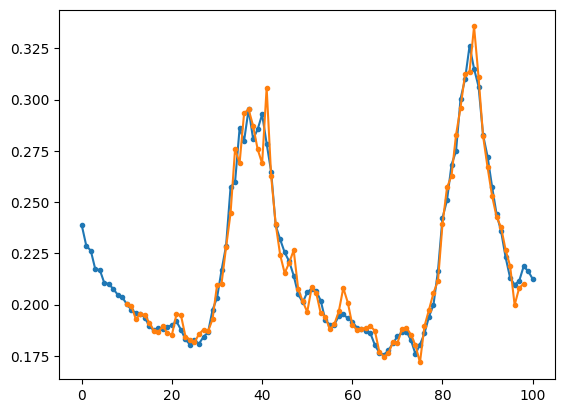

In [9]:
plt.plot(range(len(time_series)), time_series, marker=".")
plt.plot(
    range(dataset.num_past_steps, len(preds) + dataset.num_past_steps),
    preds,
    marker=".",
)